### Import / Config

In [26]:
import pandas as pd
from sqlalchemy import create_engine, text
import cred_pg as c
import matplotlib.pyplot as plt

# None = unbegrenzt
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", None)


In [5]:
engine = create_engine(
    f'postgresql://{c.pg_userid}:{c.pg_password}@{c.pg_host}/{c.pg_db}', 
    connect_args = {
        'options': '-c search_path=$user,ugeobln,umisc,umobility,usozmed,public', 
        'keepalives_idle': 120
    },
    pool_size=1, 
    max_overflow=0,
    execution_options={ 'isolation_level': 'AUTOCOMMIT' }
)

### Basis

In [3]:
sql = """
SELECT sales_month, kind_of_business, sales
FROM retail_sales
ORDER BY 1
;
"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,sales_month,kind_of_business,sales
0,1992-01-01,Used car dealers,1744.0
1,1992-01-01,"Automotive parts, acc., and tire stores",3023.0
2,1992-01-01,Furniture and home furnishings stores,3846.0
3,1992-01-01,"Furniture, home furn, electronics, and applian...",7503.0
4,1992-01-01,Furniture stores,2392.0
...,...,...,...
21835,2019-12-01,"Hobby, toy, and game stores",2265.0
21836,2019-12-01,Book stores,1037.0
21837,2019-12-01,General merchandise stores,77648.0
21838,2019-12-01,Department stores,18403.0


In [12]:
sql = """
select kind_of_business, count(*) as anz
FROM retail_sales
group by 1
ORDER BY 1
;
"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df 

,kind_of_business,anz
0,All other gen. merchandise stores,336
1,All other home furnishings stores,336
2,Automobile and other motor vehicle dealers,336
3,Automobile dealers,336
4,"Automotive parts, acc., and tire stores",336
...,...,...
60,Supermarkets and other grocery (except conveni...,336
61,Used car dealers,336
62,Used merchandise stores,336
63,Warehouse clubs and superstores,336


### Mit Lösung

#### 1

In [7]:
sql = """
select sales_month, sales
from retail_sales
where kind_of_business = 'Retail and food services sales, total'
order by sales_month
"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,sales_month,sales


<AxesSubplot: xlabel='sales_month', ylabel='Dollar (million)'>

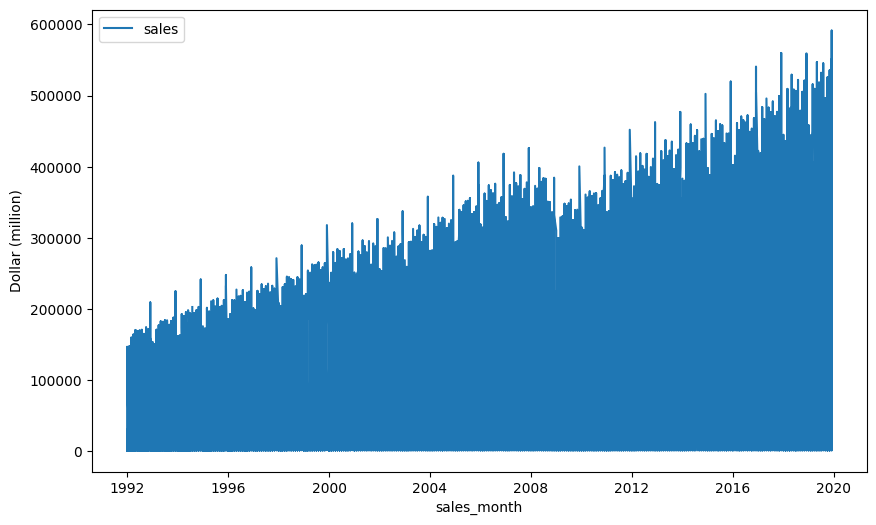

In [15]:
df.set_index('sales_month').plot(
    figsize=(10,6),
    ylabel="Dollar (million)", 
    legend=True
)

#### 2

In [17]:
sql = """
select date_part('year',sales_month) as sales_year, sum(sales) as sales
from retail_sales
where kind_of_business = 'Retail and food services sales, total'
group by 1
order by 1
"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
    df

<AxesSubplot: xlabel='sales_year', ylabel='Dollar (million)'>

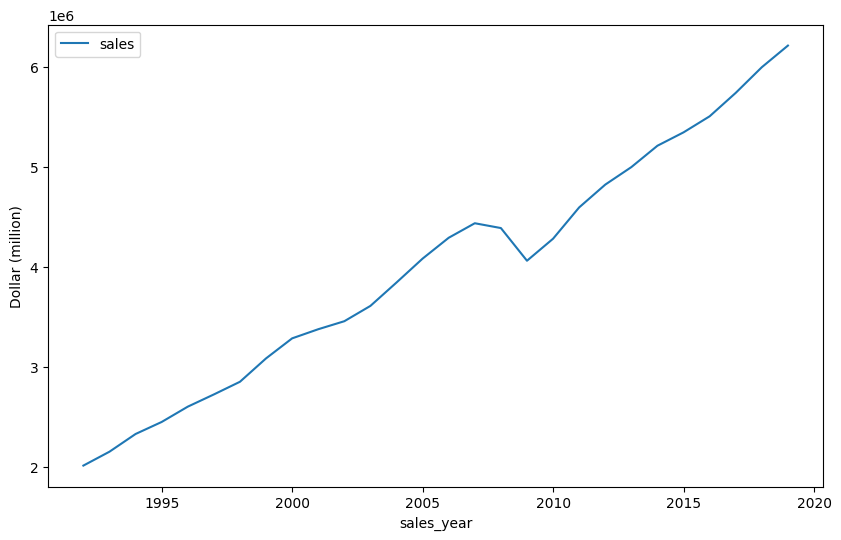

In [18]:
df.set_index('sales_year').plot(
    figsize=(10,6),
    ylabel="Dollar (million)", 
    legend=True
)

#### 3

In [22]:
sql = """
select 
  date_part('year',sales_month) as sales_year,
  kind_of_business,
  sum(sales) as sales
from retail_sales
where kind_of_business in ('Book stores','Sporting goods stores','Hobby, toy, and game stores')
group by 1,2
order by 1,2
"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df


,sales_year,kind_of_business,sales
0,1992.0,Book stores,8327.0
1,1992.0,"Hobby, toy, and game stores",11251.0
2,1992.0,Sporting goods stores,15583.0
3,1993.0,Book stores,9108.0
4,1993.0,"Hobby, toy, and game stores",11651.0
...,...,...,...
79,2018.0,"Hobby, toy, and game stores",16832.0
80,2018.0,Sporting goods stores,43857.0
81,2019.0,Book stores,8844.0
82,2019.0,"Hobby, toy, and game stores",16261.0


<Axes: xlabel='sales_year', ylabel='sales, Dollar (million)'>

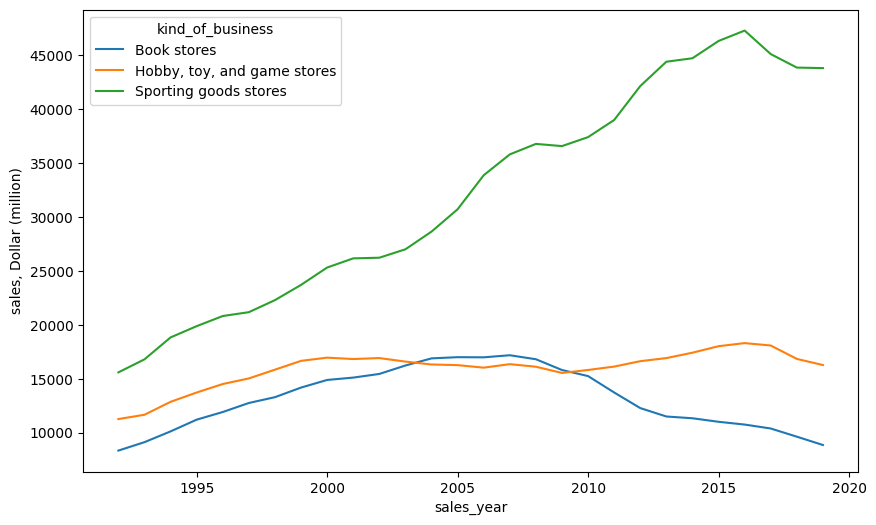

In [10]:
df.pivot(index='sales_year', columns='kind_of_business', values='sales').plot(
    figsize=(10,6),
    ylabel="sales, Dollar (million)"
)

#### 4

In [11]:
sql = """
select 
  cast(date_part('year',sales_month) as integer) as sales_year,
  kind_of_business,
  sum(sales) as sales
from retail_sales
where kind_of_business in ('Men''s clothing stores','Women''s clothing stores')
group by 1,2
order by 1
"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
# df

<Axes: xlabel='sales_year', ylabel='sales, Dollar (million)'>

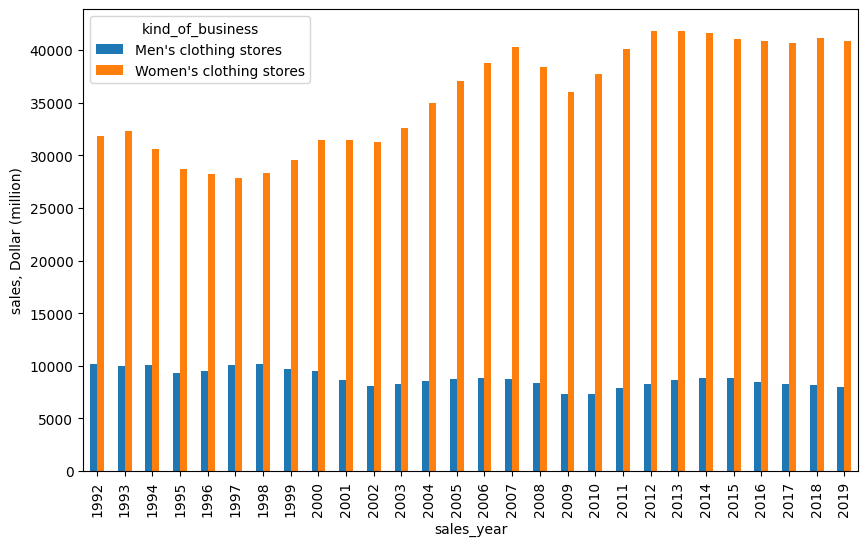

In [12]:
df.pivot(index='sales_year', columns='kind_of_business', values='sales').plot.bar(
    figsize=(10,6),
    ylabel="sales, Dollar (million)", 
)

### Ohne Lösung

#### 5

In [19]:
sql = """
with 

  w as (

    select 

      cast(date_part('year',sales_month) as integer) as sales_year,

      sum(sales) as wsales

    from retail_sales

    where kind_of_business = 'Women''s clothing stores'

    group by 1

  ),

  m as (

    select 

      cast(date_part('year',sales_month) as integer) as sales_year,

      sum(sales) as msales

    from retail_sales

    where kind_of_business = 'Men''s clothing stores'

    group by 1

  )

select sales_year, wsales - msales as sales_diff_womens_minus_mens

from w join m using(sales_year)

order by 1

"""

with engine.connect() as con:

    df = pd.read_sql_query(text(sql), con)

# df




<AxesSubplot: xlabel='sales_year', ylabel='sales, Dollar (million)'>

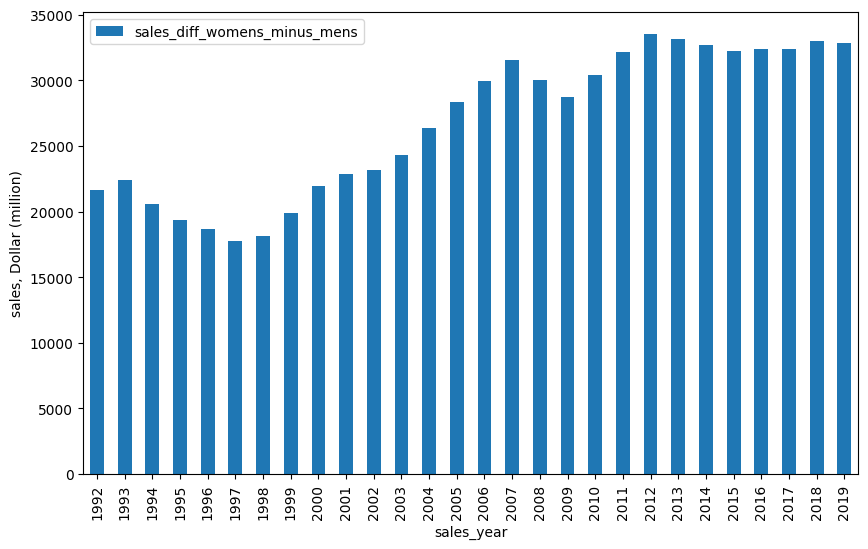

In [20]:
# Visualization
df.set_index('sales_year').plot.bar(figsize=(10,6),
    ylabel="sales, Dollar (million)",)

#### 6

In [81]:
sql = """

WITH TotalSales AS (
    SELECT
        EXTRACT(YEAR FROM sales_month) AS sales_year,
        kind_of_business,
        SUM(sales) AS total_sales
    FROM retail_sales
    WHERE kind_of_business IN ('Men''s clothing stores', 'Women''s clothing stores')
    GROUP BY 1,2
),
YearlyTotalSales AS (
    SELECT
        sales_year,
        SUM(total_sales) OVER (PARTITION BY sales_year) AS total_yearly_sales
    FROM TotalSales
)
SELECT
    TS.sales_year,
    TS.kind_of_business,
    TS.total_sales / YTS.total_yearly_sales * 100 AS percent
FROM TotalSales TS
JOIN YearlyTotalSales YTS ON TS.sales_year = YTS.sales_year
ORDER BY TS.sales_year, TS.kind_of_business;


"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,sales_year,kind_of_business,percent
0,1992.0,Men's clothing stores,24.239177
1,1992.0,Men's clothing stores,24.239177
2,1992.0,Women's clothing stores,75.760823
3,1992.0,Women's clothing stores,75.760823
4,1993.0,Men's clothing stores,23.544148
...,...,...,...
107,2018.0,Women's clothing stores,83.378222
108,2019.0,Men's clothing stores,16.340445
109,2019.0,Men's clothing stores,16.340445
110,2019.0,Women's clothing stores,83.659555


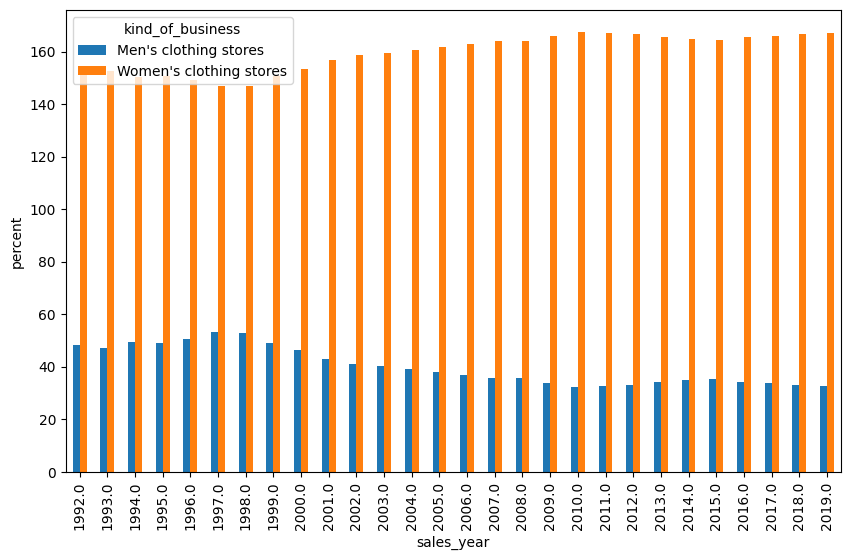

In [79]:
# Visualization


# Group and aggregate the data before pivoting
grouped_df = df.groupby(['sales_year', 'kind_of_business'])['percent'].sum().unstack()

# Create the bar plot
ax = grouped_df.plot(kind='bar', figsize=(10, 6))
ax.set_ylabel("percent")

plt.show()  # Display the plot




#### 7

In [64]:
sql = """
with 

  rs1 as (

    select 

      cast(date_part('year',sales_month) as integer) as sales_year,

      kind_of_business,

      sum(sales) as yksales

    from retail_sales
where kind_of_business in ('Men''s clothing stores','Women''s clothing stores')
    group by 1, 2

  ),

  rs2 as (

    select

      sales_year, 

      kind_of_business,

      yksales * 100 / sum(yksales) over (partition by sales_year) as percent

    from rs1

  )

select sales_year, kind_of_business, percent

from rs2

where kind_of_business in ('Men''s clothing stores','Women''s clothing stores')
"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,sales_year,kind_of_business,total_sales,total_yearly_sales,percentage
0,1992.0,Men's clothing stores,10179.0,41994.0,24.239177
1,1992.0,Women's clothing stores,31815.0,41994.0,75.760823
2,1993.0,Men's clothing stores,9962.0,42312.0,23.544148
3,1993.0,Women's clothing stores,32350.0,42312.0,76.455852
4,1994.0,Men's clothing stores,10032.0,40617.0,24.699018
...,...,...,...,...,...
51,2017.0,Women's clothing stores,40660.0,48958.0,83.050778
52,2018.0,Men's clothing stores,8208.0,49381.0,16.621778
53,2018.0,Women's clothing stores,41173.0,49381.0,83.378222
54,2019.0,Men's clothing stores,7981.0,48842.0,16.340445


<AxesSubplot: xlabel='sales_year', ylabel='percent'>

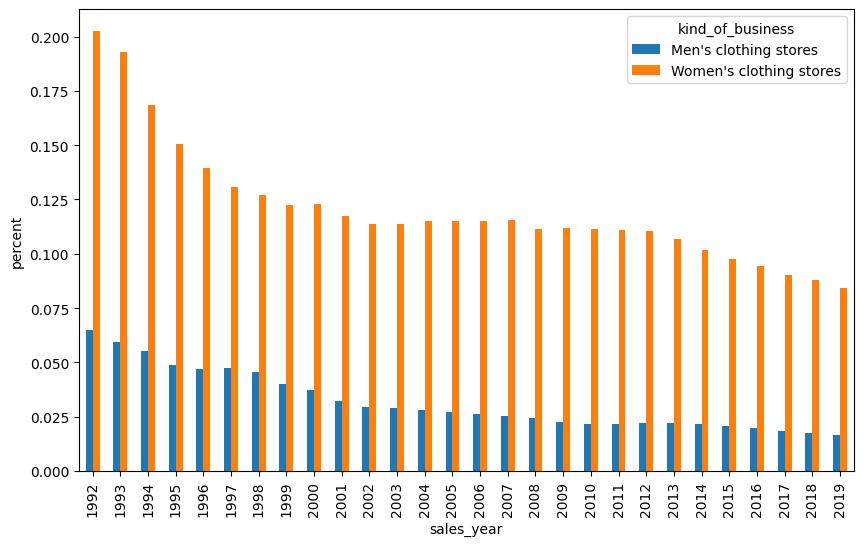

In [59]:
# Visualization

df.pivot(index='sales_year', columns='kind_of_business', values='percent').plot.bar(

    figsize=(10,6),

    ylabel="percent"

)

#### 8

In [47]:
sql = """

WITH FirstYearSales AS (
  SELECT
    kind_of_business,
    MIN(sales) AS first_year_sales
  FROM
    retail_sales
  WHERE
    EXTRACT(YEAR FROM sales_month) = 1992
  GROUP BY
    kind_of_business
)

SELECT
  EXTRACT(YEAR FROM sales_month) AS year,
  t.kind_of_business,
  (t.sales / fy.first_year_sales) - 1 AS percentage_change
FROM
  retail_sales t
JOIN
  FirstYearSales fy ON t.kind_of_business = fy.kind_of_business
ORDER BY
  year, t.kind_of_business;

"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,year,kind_of_business,percentage_change
0,1992.0,All other gen. merchandise stores,0.159166
1,1992.0,All other gen. merchandise stores,0.365703
2,1992.0,All other gen. merchandise stores,0.018001
3,1992.0,All other gen. merchandise stores,0.222170
4,1992.0,All other gen. merchandise stores,0.113690
...,...,...,...
21835,2019.0,Women's clothing stores,0.775227
21836,2019.0,Women's clothing stores,0.644421
21837,2019.0,Women's clothing stores,0.809931
21838,2019.0,Women's clothing stores,0.340630


In [2]:
# Visualization

df.set_index('year').plot.bar(
    figsize=(10,6),
    ylabel="percentage_change"
)

NameError: name 'df' is not defined

#### 9

In [65]:
sql = """
SELECT
    sales_month,
    kind_of_business,
    sales,
    AVG(sales) OVER (
        PARTITION BY kind_of_business
        ORDER BY sales_month
        ROWS BETWEEN 11 PRECEDING AND CURRENT ROW
    ) AS moving_average
FROM
     retail_sales
WHERE
    kind_of_business = 'Women''s clothing stores'
ORDER BY
    sales_month;

"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,sales_month,kind_of_business,sales,moving_average
0,1992-01-01,Women's clothing stores,1873.0,1873.000000
1,1992-02-01,Women's clothing stores,1991.0,1932.000000
2,1992-03-01,Women's clothing stores,2403.0,2089.000000
3,1992-04-01,Women's clothing stores,2665.0,2233.000000
4,1992-05-01,Women's clothing stores,2752.0,2336.800000
...,...,...,...,...
331,2019-08-01,Women's clothing stores,3325.0,3454.000000
332,2019-09-01,Women's clothing stores,3080.0,3445.833333
333,2019-10-01,Women's clothing stores,3390.0,3434.916667
334,2019-11-01,Women's clothing stores,3850.0,3409.333333


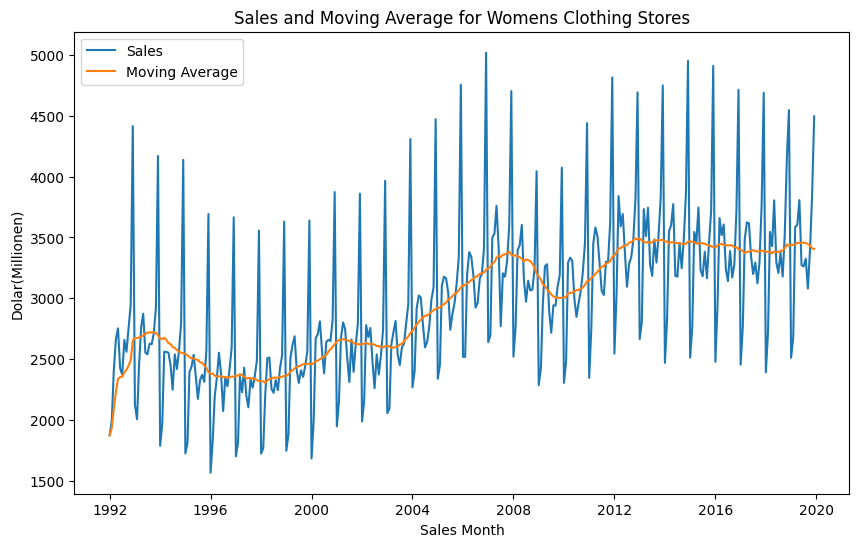

In [66]:
# Visualization
plt.figure(figsize=(10, 6))

plt.plot(df['sales_month'], df['sales'], label='Sales')
plt.plot(df['sales_month'], df['moving_average'], label='Moving Average')

plt.xlabel('Sales Month')
plt.ylabel('Dolar(Millionen)')
plt.title('Sales and Moving Average for Women''s Clothing Stores')
plt.legend()

plt.show()

#### 10

In [68]:
sql = """
SELECT 
    CASE
        WHEN EXTRACT(MONTH FROM sales_month) = 1 THEN 'January'
        WHEN EXTRACT(MONTH FROM sales_month) = 2 THEN 'February'
        WHEN EXTRACT(MONTH FROM sales_month) = 3 THEN 'March'
        WHEN EXTRACT(MONTH FROM sales_month) = 4 THEN 'April'
        WHEN EXTRACT(MONTH FROM sales_month) = 5 THEN 'May'
        WHEN EXTRACT(MONTH FROM sales_month) = 6 THEN 'June'
        WHEN EXTRACT(MONTH FROM sales_month) = 7 THEN 'July'
        WHEN EXTRACT(MONTH FROM sales_month) = 8 THEN 'August'
        WHEN EXTRACT(MONTH FROM sales_month) = 9 THEN 'September'
        WHEN EXTRACT(MONTH FROM sales_month) = 10 THEN 'October'
        WHEN EXTRACT(MONTH FROM sales_month) = 11 THEN 'November'
        WHEN EXTRACT(MONTH FROM sales_month) = 12 THEN 'December'
    END AS month_name,
    monthly_sales,
    SUM(monthly_sales) OVER (ORDER BY sales_month) AS year_to_date
FROM (
    SELECT 
        sales_month,
        SUM(sales) AS monthly_sales
    FROM retail_sales
    WHERE kind_of_business = 'Women''s clothing stores' AND EXTRACT(YEAR FROM sales_month) = 2019
    GROUP BY sales_month
) AS monthly_sales_data
ORDER BY sales_month;



"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,month_name,monthly_sales,year_to_date
0,January,2511.0,2511.0
1,February,2680.0,5191.0
2,March,3585.0,8776.0
3,April,3604.0,12380.0
4,May,3807.0,16187.0
5,June,3272.0,19459.0
6,July,3261.0,22720.0
7,August,3325.0,26045.0
8,September,3080.0,29125.0
9,October,3390.0,32515.0


<AxesSubplot: xlabel='month_name', ylabel='sales, Dollar(million)'>

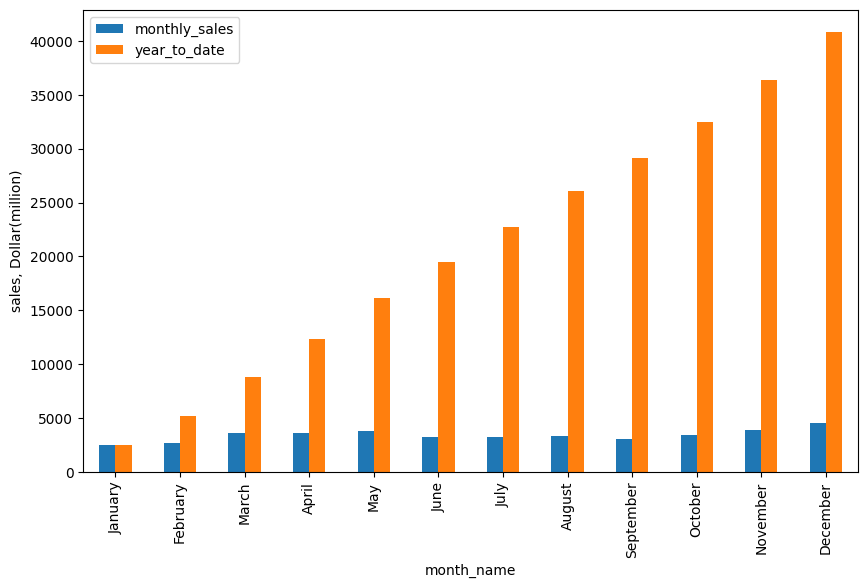

In [69]:
# Visualization


df.set_index('month_name').plot.bar(
    figsize=(10,6),
    ylabel="sales, Dollar(million)"
)

#### 11

In [6]:
sql = """
select 'dummy' as dummy
"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,dummy
0,dummy


In [ ]:
# Visualization

#### 12

In [44]:
sql = """
SELECT EXTRACT(YEAR FROM sales_month) AS year, EXTRACT(MONTH FROM sales_month) AS month, SUM(sales) AS total_sales
FROM retail_sales
WHERE kind_of_business = 'Book stores'
  AND EXTRACT(YEAR FROM sales_month) IN (2017, 2018, 2019)
GROUP BY year, month
ORDER BY year, month;

"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,year,month,total_sales
0,2017.0,1.0,1386.0
1,2017.0,2.0,676.0
2,2017.0,3.0,695.0
3,2017.0,4.0,717.0
4,2017.0,5.0,771.0
5,2017.0,6.0,689.0
6,2017.0,7.0,651.0
7,2017.0,8.0,1378.0
8,2017.0,9.0,980.0
9,2017.0,10.0,655.0


<AxesSubplot: xlabel='month', ylabel=' Dollar (million)'>

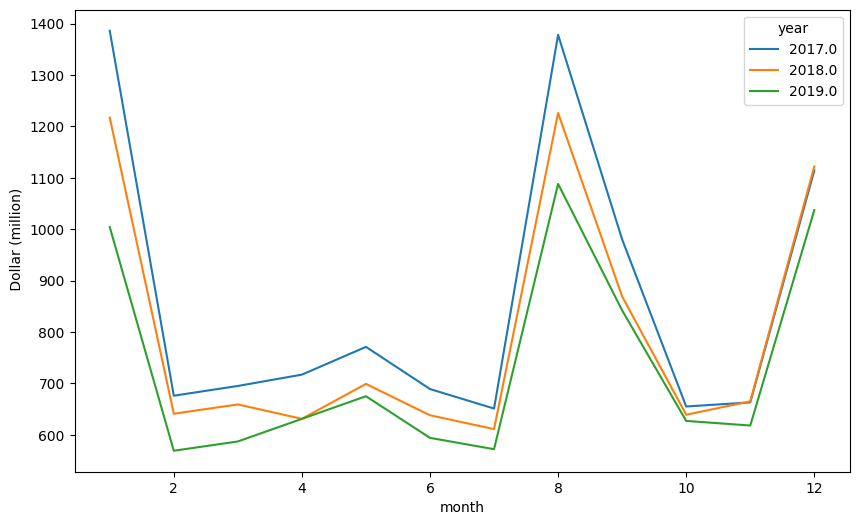

In [46]:
# Visualization
df.pivot(index='month', columns='year', values='total_sales').plot(
    figsize=(10,6),
    ylabel=" Dollar (million)"
)

#### 13

In [74]:
sql = """
WITH rs AS (
    SELECT 
        EXTRACT(YEAR FROM sales_month) AS sales_year,
        EXTRACT(MONTH FROM sales_month) AS sales_months,
        sales
    FROM retail_sales
    WHERE kind_of_business = 'Book stores'
),
jahr AS (
    SELECT
        sales_year, 
        sales_months,
        sales
    FROM rs
    WHERE sales_year IN (2018, 2019)
),
vorjahr AS (
    SELECT
        sales_year, 
        sales_months,
        sales
    FROM rs
    WHERE sales_year IN (2017, 2018)
)
SELECT
    CONCAT(jahr.sales_year, ', ', jahr.sales_months) AS Year_Month,
    jahr.sales - vorjahr.sales AS abschange
FROM jahr
LEFT JOIN vorjahr
ON jahr.sales_year = vorjahr.sales_year + 1 AND jahr.sales_months = vorjahr.sales_months
ORDER BY jahr.sales_year, jahr.sales_months;

"""
with engine.connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,year_month,abschange
0,"2018, 1",-169.0
1,"2018, 2",-35.0
2,"2018, 3",-36.0
3,"2018, 4",-86.0
4,"2018, 5",-72.0
5,"2018, 6",-51.0
6,"2018, 7",-40.0
7,"2018, 8",-152.0
8,"2018, 9",-111.0
9,"2018, 10",-16.0


<AxesSubplot: xlabel='year_month', ylabel='sales, Dollar (million)'>

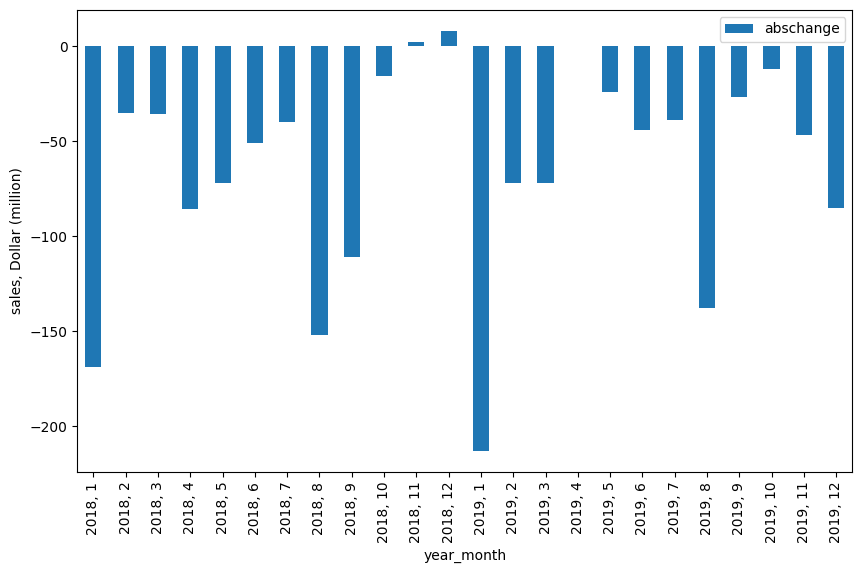

In [72]:
# Visualization

df.set_index('year_month').plot.bar(figsize=(10,6),
    ylabel="sales, Dollar (million)",)